<a href="https://colab.research.google.com/github/remre/Shift_scheduler/blob/main/Doctor_Shifts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medicals Shifts Scheduler


## Motivation
This model created to optimize monthly shift schedule of medical doctors in ER.
Model highly inspried by Gurobi's own examples and also Gurobi library used to optimize the schedule

## Optimization Process

In this modeling example, we tackle a multi-objective model where the primary objective is to minimize the number of extra workers required to satisfy shift requirements, and the secondary objective is to minimize the maximum difference in the number of shifts worked between any pair of workers. This secondary objective balances the workload allocated to workers.
 
The hierarchical multi-objective optimization approach will first solve the following model with the primary objective.

### Objective Function

- **Primary objective:** The objective function is to minimize the number of extra workers allocated. 

\begin{equation}
\text{Min} \quad totSlack
\tag{0}
\end{equation}

### Constraints

- **Shift requirements:**  All shifts requirements most be satisfied.

\begin{equation}
\sum_{w \: \in \: workers} x(w,s)  +  Slack(s) = \text{shiftRequirements}(s) \quad \forall \; s \in \text{shifts}
\tag{1}
\end{equation}

- **Temps:** Compute the total number of extra workers required.

\begin{equation}
\sum_{s \: \in \: \text{shifts}} Slack(s) =  totSlack 
\tag{2}
\end{equation}

- **Shifts:**  Compute the total number of shifts for each worker.

\begin{equation}
\sum_{s \: \in \: \text{shifts}} x(w,s)  = \text{totShifts}(w) \quad \forall \; w \in workers
\tag{3}
\end{equation}

- **Binary and non-negativity constraints:**

$$
x(w,s) \in \{0, 1 \}  \quad \forall \; (w,s) \in availability
$$

$$
Slack(s) \geq 0 \quad  \forall \; s \in \text{shifts}
$$

$$
\text{totShifts}(w) \geq 0 \quad \forall \; w \in workers
$$

$$
totSlack  \geq 0
$$

The parameter $Opt(totSlack)$ is set to be equal to the minimum number of extra workers required to satisfy demand. That is, $Opt(totSlack) = totSlack^{*} $, where $totSlack^{*} $ is the optimal value of the variable $totSlack$.

For a given relative tolerance of primary objective $relTol$, we now solve the following model where we minimize the secondary objective.


### Objective Function

- **Secondary objective:** The objective function is to minimize the difference between the maximum number of shifts allocated to a worker, and the minimum number of shifts allocated to a worker. 

\begin{equation}
\text{Min} \quad ( \text{maxShift} -  \text{minShift} )
\tag{4}
\end{equation}

### Constraints

- **Shift requirements:**  All shifts requirements most be satisfied.

\begin{equation}
\sum_{w \: \in \: workers} x(w,s)  +  Slack(s) = \text{shiftRequirements}(s) \quad \forall \; s \in \text{shifts}
\tag{1}
\end{equation}


- **Relative tolerance:**  Ensure that the total number of extra workers (totSlack) minimized by the primary objective is satisfied up to a tolerance percentage.

\begin{equation}
\sum_{s \: \in \: shifts} Slack(s) \leq (1+relTol)*Opt(totSlack)
\tag{5}
\end{equation}

- **Shifts:**  Compute the total number of shifts for each worker.

\begin{equation}
\sum_{s \: \in \: \text{shifts}} x(w,s)  = \text{totShifts}(w) \quad \forall \; w \in workers
\tag{3}
\end{equation}

- **Minimum shifts:**  Compute the minimum number of shifts allocated to an employed worker. For our problem minimum number of shift per doctor will be 8 in a month


\begin{equation}
\text{minShift} = \text{Min} \{\text{totShifts}(w): \ w \; in \; workers \}  
\tag{6}
\end{equation}


- **Maximum shifts:**  Compute the maximum number of shifts allocated to an employed worker. The maximum number of shift will be constraint to 10 in a month.

\begin{equation}
\text{maxShift} = \text{Max} \{\text{totShifts}(w): \ w \; in \; workers \}
\tag{7}
\end{equation}

- **Day After Rest:** Each med have to day off at least one day after 24 hour shift.  


- **Binary and non-negativity constraints:**

$$
x(w,s) \in \{0, 1 \}  \quad \forall \; (w,s) \in availability
$$

$$
Slack(s) \geq 0 \quad  \forall \; s \in \text{shifts}
$$

$$
\text{totShifts}(w) \geq 0 \quad   \forall \; w \in workers
$$

$$
\text{maxShift},  \text{minShift}   \geq 0
$$

This optimization process is done automatically by the Gurobi Python API when using the following method: 

"Model.setObjectiveN()"

## Python Implementation

We now import the Gurobi Python Module. Then, we initialize the data structures with the given data.

In [1]:
%pip install gurobipy

In [2]:
# This command imports the Gurobi functions and classes.
import gurobipy as gp
from gurobipy import GRB
# other necessary libraries
import pandas as pd
from pylab import *
import matplotlib
import matplotlib.pyplot as plt

In [3]:
# # Amount each worker is paid to work one shift.
workers, pay = gp.multidict({
  "Dmitri":   12,
  "Jason": 10,
  "Marissa":   8,
  "Ferdinand":   10,
  "Masallah":    8,
  })

In [4]:
# number of days in February 2022, it can be  changed to any other (30/31)
x = range(1,29)
Shifts  = []
Shifts = [str(i) for i in x]

In [5]:
# Number of workers required for each shift
S = [1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2,2, 2, 2,1, 1, 1,2,1,2,2,2,2,1,1,2]

shiftRequirements = {s: S[i] for i, s in enumerate(Shifts)}

In [6]:
# Assume everyone is available give one for avaliability 
availability = pd.DataFrame(np.ones((len(workers), len(Shifts))), index=workers, columns=Shifts)

# Here is the days and meds whose are unavaliable the day that given
availability.at['Dmitri','1'] = 0
availability.at['Jason','1'] = 0
availability.at['Jason','9'] = 0
availability.at['Jason','4'] = 0
availability.at['Marissa','14'] = 0
availability.at['Masallah','1'] = 0
availability.at['Masallah','2'] = 0
availability.at['Masallah','3'] = 0
availability.at['Masallah','4'] = 0
availability.at['Dmitri','23'] = 0
availability.at['Dmitri','24'] = 0
availability.at['Dmitri','22'] = 0
availability.at['Dmitri','7'] = 0
availability.at['Dmitri','5'] = 0
availability.at['Dmitri','6'] = 0


# Create availability dictionary to be used in decision variable bounding
avail = {(w,s) : availability.loc[w,s] for w in workers for s in Shifts}

In [7]:
# Create initial model.
m = gp.Model("workforce5")

Restricted license - for non-production use only - expires 2023-10-25


### Decision Variables

$x(w,s) \in \{0,1\}$: This variable equals 1 if worker $w \in workers$ is assigned to shift $s \in \text{shifts}$, 
and 0 otherwise.
This decision variable is defined over the $availability$ set.

$Slack(s) \geq 0$: This variable is the number of extra workers required to satisfy the requirements of shift $s$.

In [8]:
# Initialize assignment decision variables.

x = m.addVars(avail.keys(), vtype=GRB.BINARY, name="x")

In [9]:
# New variables: z[w,s] == 1 if worker w works shift s, but not shift s-1
z = m.addVars(avail.keys(), vtype=GRB.BINARY, name="start")


In [10]:
# Slack decision variables determine the number of extra workers required to satisfy the requirements 
# of each shift
slacks = m.addVars(Shifts, name="Slack")
# if (x[w, s1], x[w, s2] for w in workers for s1,s2 in zip(Shifts, Shifts[2:]))

### Auxiliary Variables
Auxiliary variables are derived from the values of the decision variables.

$totSlack$: This variable counts the total number of extra workers required to satisfy the demand for shift workers.

$\text{totShifts}(w)$: This variable counts the total number of shifts worked by each worker $w \in workers$.

$\text{minShift}$: This variable determines the minimum number of shifts allocated to workers. 

$\text{maxShift}$: This variable  determines the maximum number of shifts allocated to workers.

In [11]:
# Auxiliary variable totSlack to represent the total number of extra workers required to satisfy the 
# requirements of all the shifts.
totSlack = m.addVar(name='totSlack')

In [12]:
# Auxiliary variable totShifts counts the total shifts worked by each employed worker
totShifts = m.addVars(workers, name="TotShifts")

In [13]:
# Constraint: All shifts requirements most be satisfied.

# shift_reqmtsz = m.addConstrs((x.sum('*',w,s2,s1)<=2 for w in workers for s1,s2 in zip(Shifts, Shifts[2:])), name='shiftRequirement')
shift_reqmts = m.addConstrs((x.sum('*',s) + slacks[s] == shiftRequirements[s] for s in Shifts), name='shiftRequirement')

In [14]:
# Constraint: set the auxiliary variable (totSlack) equal to the total number of extra workers 
# required to satisfy shift requirements
num_temps = m.addConstr(totSlack == slacks.sum(), name='totSlack')

### Constraint

$$\sum_{s \: \in \: shifts} x(w,s) \; = \; \text{totShifts}(w) \; \; \forall \ w \; in \; workers$$

In [15]:
# Constraint: compute the total number of shifts for each worker

num_shifts = m.addConstrs((totShifts[w] == x.sum(w,'*') for w in workers), name='totShifts')

In [16]:
# # Range of shifts that every workers is required to stay between
minShifts = 8
maxShifts = 10

# If you want to determine number of shifts with respect to fairness here is the solution
# minShift = m.addVar(name='minShift')
# maxShift = m.addVar(name='maxShift')
# m.setObjectiveN(maxShift - minShift, index=1, priority=2, name='Fairness')

In [17]:
minShiftsConstr = m.addConstrs(((
    x.sum(w,'*') >= minShifts for w in workers)
), name='minShifts')


In [18]:
maxShiftsConstr = m.addConstrs(((
    x.sum(w,'*') <= maxShifts for w in workers)
), name='maxShifts')


In [19]:
dayoffcons = m.addConstrs((x[w, s1] + x[w, s2] <= 1 for w in workers for s1,s2 in zip(Shifts, Shifts[1:])), name='ThisisIT!')

In [20]:
# Set up primary objective.

# The setObjectiveN() method of the model object m allows to define multiple objectives.
# The first argument is the linear expression defining the most important objective, called primary 
# objective, in this case it is the minimization of extra workers required to satisfy shift 
# requirements. 
# The second argument is the index of the objective function, we set the index of the primary 
# objective to be equal to 0. 
# The third argument is the priority of the objective.
# The fourth argument is the relative tolerance to degrade this objective when a lower priority
# objective is optimized. The fifth argument is the name of this objective.
# A hierarchical or lexicographic approach assigns a priority to each objective, and optimizes 
# for the objectives in decreasing priority order. 
# For this problem, we have two objectives, and the primary objective has the highest priority 
# which is equal to 2. 
# When the secondary objective is minimized, since the relative tolerance is 0.2, we can only 
# increase the minimum number of extra workers up to 20%. 
# For example if the minimum number extra workers is 10, then when optimizing the secondary objective 
# we can have up to 12 extra workers.

# here how we can add salarise to our objective as minimum
# m.setObjective(gp.quicksum(pay[w]*x[w, s] for w, s in avail.keys()), GRB.MINIMIZE)



m.setObjectiveN(totSlack, index=0, priority=2, reltol=0.2, name='TotalSlack')

In [22]:
# Set up secondary objective.

# The secondary objective is called fairness and its goal is to balance the workload assigned 
# to the employed workers. 
# To balance the workload assigned to the employed workers, we can minimize the difference 
# between the maximum number of shifts assigned to an employed worker and the minimum number 
# of shifts assigned to an employed worker.



In [21]:
# Save model formulation for inspection

m.write('workforce.lp')

In [22]:
# Optimize
# This method runs the optimization engine to solve the MIP problem in the model object m
m.optimize()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 179 rows, 314 columns and 892 nonzeros
Model fingerprint: 0x7d9cbcca
Variable types: 34 continuous, 280 integer (280 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 1 objectives ... 
---------------------------------------------------------------------------
---------------------------------------------------------------------------

Multi-objectives: optimize objective 1 (TotalSlack) ...
---------------------------------------------------------------------------

Optimize a model with 179 rows, 314 columns and 892 nonzeros
Model fingerprint: 0x227c1ffc
Variable types: 34 continuous, 280 integer 

In [23]:
# The Status attribute  provides current optimization status of the model object m
# In workforce model, we check if the model is infeasible or unbounded and report this situation
status = m.Status
if status == GRB.Status.INF_OR_UNBD or status == GRB.Status.INFEASIBLE  or status == GRB.Status.UNBOUNDED:
    print('The model cannot be solved because it is infeasible or unbounded')
    sys.exit(0)
# If the optimization status of the model is not optimal for some other reason, we report that 
# situation.
if status != GRB.Status.OPTIMAL:
    print('Optimization was stopped with status ' + str(status))
    sys.exit(0)

                    KPI Value
0  Total slack required   0.0
--------------------------------------------------
Shifts
      Worker  Number of shifts
0     Dmitri               9.0
1      Jason               8.0
2    Marissa               8.0
3  Ferdinand              10.0
4   Masallah               8.0


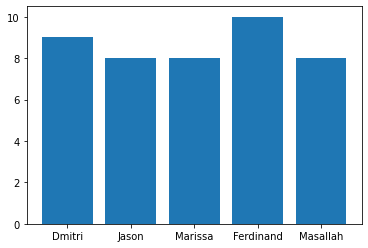

--------------------------------------------------
Assigments
Symbols: '-': not working, '*': working
      worker  1  2  3  4  5  6  7  8  9  ... 19 20 21 22 23 24 25 26 27 28
0     Dmitri  -  *  -  *  -  -  -  *  -  ...  -  -  -  -  *  -  *  -  *  -
1      Jason  -  -  *  -  *  -  *  -  -  ...  -  -  *  -  *  -  -  *  -  -
2    Marissa  -  -  *  -  -  *  -  -  *  ...  -  -  *  -  -  *  -  -  -  -
3  Ferdinand  *  -  -  -  -  -  -  *  -  ...  *  -  -  *  -  -  *  -  -  *
4   Masallah  -  *  -  -  -  -  *  -  *  ...  -  *  -  -  -  *  -  *  -  -

[5 rows x 29 columns]


In [24]:

# Print total slack and the number of shifts worked for each worker
# The KPIs for this optimization number is the number of extra worked required to satisfy 
# demand and the number of shifts that each employed worker is working.
solution = {}
shifts_sol = {}
solution['Total slack required'] = str(totSlack.X)
assignments_all = {}
gant={}

assignments = dict()
for [w, s] in avail:
    if x[w, s].x == 1:
        if w in assignments:
            assignments[w].append(s)
        else:
            assignments[w] = [s]



print(pd.DataFrame.from_records(list(solution.items()), columns=['KPI', 'Value']))
print('-'*50)

for w in workers:
    shifts_sol[w]=totShifts[w].X
    assignments_all[w]=assignments.get(w, [])

print('Shifts')
print(pd.DataFrame.from_records(list(shifts_sol.items()), columns=['Worker', 'Number of shifts']))
    
y_pos = np.arange(len(shifts_sol.keys())) 
plt.bar(y_pos,shifts_sol.values() , align='center')
plt.xticks(y_pos, shifts_sol.keys())
plt.show()

print('-'*50)
for w in assignments_all:
    gant[w] = [w]
    for d in Shifts:
        gant[w].append('*' if d in assignments_all[w] else '-')

print('Assigments')
print('Symbols: \'-\': not working, \'*\': working')
pd.set_option('display.width', 1000)
df = pd.DataFrame.from_records(list(gant.values()), columns=['worker']+Shifts)
print(pd.DataFrame.from_records(list(gant.values()), columns=['worker']+Shifts))

In [25]:
assignments_all

{'Dmitri': ['2', '4', '8', '10', '14', '16', '23', '25', '27'],
 'Ferdinand': ['1', '8', '10', '13', '15', '17', '19', '22', '25', '28'],
 'Jason': ['3', '5', '7', '11', '16', '21', '23', '26'],
 'Marissa': ['3', '6', '9', '12', '15', '17', '21', '24'],
 'Masallah': ['2', '7', '9', '14', '18', '20', '24', '26']}

In [26]:
df

,worker,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,Dmitri,-,*,-,*,-,-,-,*,-,...,-,-,-,-,*,-,*,-,*,-
1,Jason,-,-,*,-,*,-,*,-,-,...,-,-,*,-,*,-,-,*,-,-
2,Marissa,-,-,*,-,-,*,-,-,*,...,-,-,*,-,-,*,-,-,-,-
3,Ferdinand,*,-,-,-,-,-,-,*,-,...,*,-,-,*,-,-,*,-,-,*
4,Masallah,-,*,-,-,-,-,*,-,*,...,-,*,-,-,-,*,-,*,-,-


In [ ]:
df.to_csv('first.csv',index= False)